In [780]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd

In [244]:
data = pd.read_csv("DebrisFlow.txt",sep ='\t',header = None)

In [963]:
model = pyo.ConcreteModel()

In [964]:
I = np.arange(len(data)) + 1

In [965]:
B = np.arange(9)+1


In [966]:
model.Iset = pyo.Set(initialize=I)

In [967]:
model.Bset = pyo.Set(initialize=B)

In [968]:
model.I = pyo.Param(initialize=len(I))

In [969]:
model.B = pyo.Param(initialize=len(B))

In [970]:
M = [max( abs(data.iloc[i][1] - 0.29*data.iloc[i][0]-25) , abs(data.iloc[i][1] - 0.29*data.iloc[i][0]+94),
        abs(data.iloc[i][1]-25) , abs(data.iloc[i][1] +94)) for i in range(len(data))]

M2 = [199+0.3*data.iloc[i][0] for i in range(len(data))]

In [971]:
def M_rule(model,i):
    return M[i-1]

def M2_rule(model,i):
    return M2[i-1]

In [972]:
model.M = pyo.Param(model.Iset,initialize=M_rule)
model.M2 = pyo.Param(model.Iset,initialize=M2_rule)

In [973]:
def rule_x(model,i):
    return data.iloc[i-1][0]
def rule_y(model,i):
    return data.iloc[i-1][1]

In [974]:
model.X = pyo.Param(model.Iset,initialize=rule_x)
model.Y = pyo.Param(model.Iset,initialize=rule_y)

In [975]:
model.c = pyo.Var(model.Bset,domain=pyo.Reals)
model.d = pyo.Var(model.Bset,domain=pyo.Reals)

In [976]:
model.eps = pyo.Var(model.Iset,domain = pyo.NonNegativeReals)

In [977]:
model.delta = pyo.Var(model.Iset,model.Bset,domain = pyo.Binary)

In [978]:
model.deltap = pyo.Var(model.Iset,model.Bset,domain=pyo.Reals, bounds=(0,1))
model.deltan = pyo.Var(model.Iset,model.Bset,domain=pyo.Reals, bounds=(0,1))

In [979]:
model.gamma = pyo.Var(model.Bset,domain=pyo.Binary)

In [980]:
model.Z = pyo.Var(model.Bset,domain=pyo.Binary)

In [981]:
k = 3

model.k = pyo.Param(initialize=k)

# constraint 1


In [982]:
def rc1(model,i,b):
    
    if b > model.B - model.k:
        return pyo.Constraint.Skip
    
    return model.Y[i] - (model.c[b]*model.X[i]+model.d[b]) <= model.eps[i] + model.M[i]*(1-model.delta[i,b])

In [983]:
model.const1 = pyo.Constraint(model.Iset,model.Bset,rule = rc1)

# constraint 2


In [984]:
def rc2(model,i,b):
    
    if b > model.B - model.k:
        return pyo.Constraint.Skip
    
    return (model.c[b]*model.X[i]+model.d[b]) - model.Y[i]  <= model.eps[i] + model.M[i]*(1-model.delta[i,b])

In [985]:
model.const2 = pyo.Constraint(model.Iset,model.Bset,rule = rc2)

# constraint 3


In [986]:
def rc3(model,i):
    
    return sum(model.delta[i,b] for b in model.Bset if b<=model.B-model.k) == 1

In [987]:
model.const3 = pyo.Constraint(model.Iset,rule=rc3)

# constraint 4


In [988]:
def rc4(model,i,b):
    
    if i == model.I:
        return pyo.Constraint.Skip
    
    if b > model.B - model.k - 1:
        return pyo.Constraint.Skip

    
    return model.delta[i+1,b+1] <= model.delta[i,b] + model.delta[i,b+1]

In [989]:
model.const4 = pyo.Constraint(model.Iset,model.Bset,rule=rc4)

# constraint 5


In [990]:
def rc5(model,i):
    
    if i == model.I:
        return pyo.Constraint.Skip
    
    return model.delta[i+1,1] <= model.delta[i,1]

In [991]:
model.const5 = pyo.Constraint(model.Iset,rule=rc5)

# constraint 6


In [992]:
def rc6(model,i):
    
    if i == model.I:
        return pyo.Constraint.Skip
    
    return model.delta[i,model.B-model.k] <= model.delta[i+1,model.B - model.k]

In [993]:
model.const6 = pyo.Constraint(model.Iset,rule=rc6)

# constraint 7


In [994]:
def rc7(model):
    return sum(model.Z[b] for b in model.Bset if b <= model.B-model.k-1) == model.k - 1

In [995]:
model.const7 = pyo.Constraint(rule=rc7)

# constraint 8


In [996]:
def rc8(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B - model.k - 1:
        return pyo.Constraint.Skip
    return model.delta[i,b] + model.delta[i+1,b+1] + model.gamma[b] - 2 <= model.deltap[i,b] + model.Z[b]

In [997]:
model.const8 = pyo.Constraint(model.Iset, model.Bset, rule=rc8)

# constraint 9


In [998]:
def rc9(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B - model.k - 1:
        return pyo.Constraint.Skip
    return model.delta[i,b] + model.delta[i+1,b+1] + 1 - model.gamma[b] - 2 <= model.deltan[i,b] + model.Z[b]

In [999]:
model.const9 = pyo.Constraint(model.Iset,model.Bset,rule=rc9)

# constraint 10


In [1000]:
def rc10(model,i,b):
    
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B - model.k - 1:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b] >= model.X[i]*(model.c[b] - model.c[b+1]) - model.M2[i]*(1-model.deltap[i,b])

In [1001]:
model.const10 = pyo.Constraint(model.Iset,model.Bset,rule=rc10)

# constraint 11


In [1002]:
def rc11(model,i,b):
    
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B - model.k - 1:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b] <= model.X[i+1]*(model.c[b] - model.c[b+1]) - model.M2[i+1]*(1-model.deltap[i,b])

In [1003]:
model.const11 = pyo.Constraint(model.Iset,model.Bset,rule=rc11)

# constraint 12


In [1004]:
def rc12(model,i,b):
    
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B - model.k - 1:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b] <= model.X[i]*(model.c[b] - model.c[b+1]) - model.M2[i]*(1-model.deltan[i,b])

In [1005]:
model.const12 = pyo.Constraint(model.Iset,model.Bset,rule=rc12)

# constraint 13


In [1006]:
def rc13(model,i,b):
    
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B - model.k - 1:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b] >= model.X[i+1]*(model.c[b] - model.c[b+1]) - model.M2[i+1]*(1-model.deltan[i,b])

In [1007]:
model.const13 = pyo.Constraint(model.Iset,model.Bset,rule=rc13)

# constraint 14

In [1008]:
def rc14(model,b):
    if b > model.B-model.k:
        return pyo.Constraint.Skip
    
    return sum(model.delta[i,b] for i in model.Iset) >= 2

In [1009]:
model.const14 = pyo.Constraint(model.Bset,rule=rc14)

# objective

In [1010]:
def ro(model):
    return sum(model.eps[i] for i in model.Iset)

In [1011]:
model.obj = pyo.Objective(rule=ro,sense = pyo.minimize)

In [1012]:
markers = {1:'o',2:'x',3:'*',4:'D',5:'V'}

# solution

In [1013]:
solver = pyo.SolverFactory('glpk')

In [1014]:
opt = {'tmlim':1200}

In [ ]:
result = solver.solve(model,'glpk')

In [959]:
import matplotlib.pyplot as plt

# plotting

In [960]:
def draw():
    m = 1
    plt.figure(figsize=(10,6))
    for b in model.Bset:


        if b > model.B - model.k:
            break
        cc = pyo.value(model.c[b])
        dd = pyo.value(model.d[b])
        px = 0
        py=0
        pyy = 0
        if b > 1 and pyo.value(model.Z[b-1])==0:
            px = x[-1]
            py = y[-1]
            pyy = y_org[-1]



        x = []
        y = []
        y_org = []

        if b > 1 and pyo.value(model.Z[b-1])==0:
            x.append(px)
            y.append(py)
            y_org.append(pyy)


        for i in model.Iset:
            if pyo.value(model.delta[i,b]) == 1:
                x.append(pyo.value(model.X[i]))
                y.append(cc*pyo.value(model.X[i])+dd)
                y_org.append(pyo.value(model.Y[i]))

        plt.scatter(x,y_org,marker=markers[m],label=f"cluster {m}")

        if b<=model.B-model.k-1 and pyo.value(model.Z[b])==1:
            m+=1
        plt.plot(x,y,label = f"segment{b}")

    plt.legend()
    plt.show()

# 7 breakpoints, 3 clusters

In [962]:
print(result)


Problem: 
- Name: unknown
  Lower bound: 65.0522276124101
  Upper bound: 65.0522276124101
  Number of objectives: 1
  Number of constraints: 1391
  Number of variables: 493
  Number of nonzeros: 6193
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 6325
      Number of created subproblems: 6325
  Error rc: 0
  Time: 40.66535568237305
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



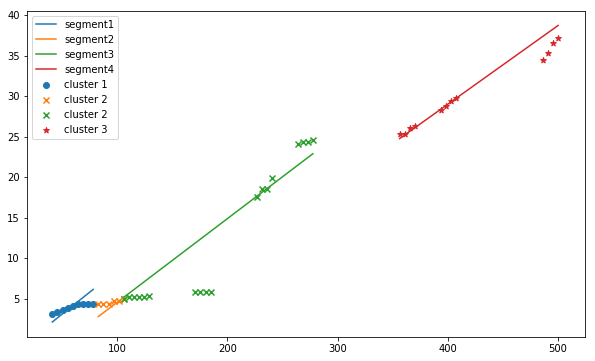

In [961]:
draw()

# 6 breakpoints, 3 clusters

In [715]:
print(result)


Problem: 
- Name: unknown
  Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 611
  Number of variables: 225
  Number of nonzeros: 2473
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: infeasible
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.6101529598236084



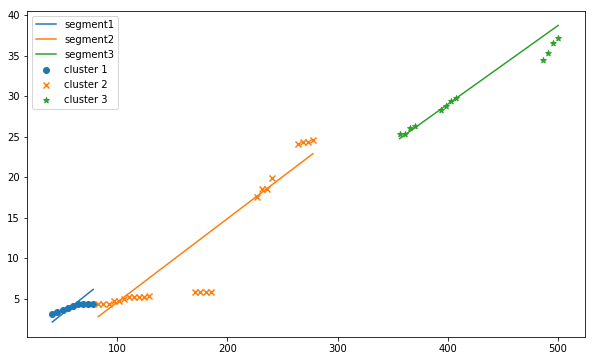

In [658]:
m = 1
plt.figure(figsize=(10,6))
for b in model.Bset:
    
    
    if b > model.B - model.k:
        break
    cc = pyo.value(model.c[b])
    dd = pyo.value(model.d[b])
    
    
    
    x = []
    y = []
    y_org = []
    
    for i in model.Iset:
        if pyo.value(model.delta[i,b]) == 1:
            x.append(pyo.value(model.X[i]))
            y.append(cc*pyo.value(model.X[i])+dd)
            y_org.append(pyo.value(model.Y[i]))

    plt.scatter(x,y_org,marker=markers[m],label=f"cluster {m}")
    
    if b<=model.B-model.k-1 and pyo.value(model.Z[b])==1:
        m+=1
    plt.plot(x,y,label = f"segment{b}")
    
plt.legend()
plt.show()

# 6 breakpoints, 2 clusters

In [773]:
print(result)


Problem: 
- Name: unknown
  Lower bound: 72.9426777077625
  Upper bound: 72.9426777077625
  Number of objectives: 1
  Number of constraints: 1391
  Number of variables: 493
  Number of nonzeros: 6193
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 39325
      Number of created subproblems: 39325
  Error rc: 0
  Time: 216.1810429096222
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



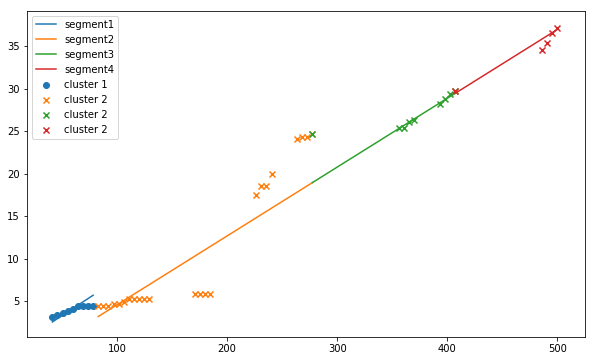

In [787]:
draw()